In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp

import numpy as np

import openmm
import openmm, openmm.app
from openmm import unit

kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

import mdtraj as md
import nglview as nv

from jax_dataclasses import pytree_dataclass

import flox

In [3]:
#some useful stuff
def water_mdtraj_topology(n_waters, n_sites=3):
    H = md.element.Element.getBySymbol('H')
    O = md.element.Element.getBySymbol('O')
    VS = md.element.Element.getBySymbol('VS')
    water_top = md.Topology()
    water_top.add_chain()
    for i in range(n_waters):
        water_top.add_residue('HOH', water_top.chain(0))
        water_top.add_atom('O', O, water_top.residue(i))
        water_top.add_atom('H1', H, water_top.residue(i))
        water_top.add_atom('H2', H, water_top.residue(i))
        if n_sites == 4:
            water_top.add_atom('M', VS, water_top.residue(i))
        water_top.add_bond(water_top.atom(n_sites*i), water_top.atom(n_sites*i+1))
        water_top.add_bond(water_top.atom(n_sites*i), water_top.atom(n_sites*i+2))
    return water_top

def get_view(positions,  box):
    if len(positions.shape) == 3 and len(box.shape) == 1:
        all_boxes = np.full((len(positions),len(box)), box)
    else:
        all_boxes = box
    unitcell = {'unitcell_lengths' : all_boxes,
                'unitcell_angles' : np.full(all_boxes.shape, 90)}

    view = nv.show_mdtraj(md.Trajectory(positions, model.mdtraj_topology, **unitcell))
    view.add_unitcell()
    view.add_representation('ball+stick', selection="water")
    return view

class ModelWrapper():
    def __init__(self, system: openmm.System, mdtraj_topology: md.Topology, positions: np.ndarray):
        assert system.getNumParticles() == mdtraj_topology.n_atoms
        assert len(positions) == system.getNumParticles()
        self.system = system
        self.mdtraj_topology = mdtraj_topology
        self.topology = mdtraj_topology.to_openmm()
        self.positions = positions

In [4]:
# set PRNG seed
seed = 42

# set PRNG key chain
chain = flox.util.key_chain(seed)

In [5]:
data = np.load("./data-iceIh_tip4pew-T270.npz")

In [6]:
data["positions"].shape

(64, 3)

In [7]:
data["box"]

array([0.92233076, 0.80326499, 0.71133756])

In [255]:
#load system from file
temp = 270
water_type = 'tip4pew'
info = f'iceIh_{water_type}-T{temp}'

box = np.load(f'data-{info}.npz')['box']
positions = np.load(f'data-{info}.npz')['positions']
with open(f'system-{info}.xml') as input:
    system = openmm.XmlSerializer.deserialize(input.read())

default_box_tensor = np.array([a.value_in_unit(unit.nanometer) for a in system.getDefaultPeriodicBoxVectors()])
if not np.allclose(np.eye(3)*box, default_box_tensor):
    print('WARNING: box mismatch, resetting it')
    model.system.setDefaultPeriodicBoxVectors(*np.eye(3)*box)
n_sites = int(''.join(x for x in water_type if x.isdigit())) #get n_sites from water_type name
assert system.getNumParticles() % n_sites == 0
n_waters = system.getNumParticles()//n_sites
mdtraj_topology = water_mdtraj_topology(n_waters, n_sites)

model = ModelWrapper(system, mdtraj_topology, positions)
print('Total water molecules:', n_waters)
get_view(model.positions, box)

Total water molecules: 16


NGLWidget()

In [9]:
pace = 500
n_iter = 1_000

integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1/unit.picosecond, 1*unit.femtosecond)
if isinstance(model.system.getForces()[-1], (openmm.MonteCarloBarostat, openmm.MonteCarloAnisotropicBarostat, openmm.MonteCarloFlexibleBarostat)):
    model.system.getForces()[-1].setDefaultTemperature(temp)
# model.system.setDefaultPeriodicBoxVectors(*np.eye(3)*new_box) #the box must also be set if starting from position different from model.positions
simulation = openmm.app.Simulation(model.topology, model.system, integrator)


In [13]:
pos = model.positions
state = simulation.context.getState()
box = state.getPeriodicBoxVectors(asNumpy=True).value_in_unit(unit.nanometer)

In [14]:
context = simulation.context
context.reinitialize(preserveState=True)

In [58]:
import matplotlib.pyplot as plt

top = water_mdtraj_topology(1, 4)
pos_ = pos + 0.
pos_[3] += .04
nv.show_mdtraj(md.Trajectory(pos_[0:4], top))

NGLWidget()

In [170]:
from flox.flow import rigid
from flox import geom

i = 13



In [171]:
box

array([[0.92233076, 0.        , 0.        ],
       [0.        , 0.80326499, 0.        ],
       [0.        , 0.        , 0.71133756]])

In [231]:
data = np.load("foo.npz")
p_ = data["positions"]
b_ = data["box"]
p_.shape, b_.shape

torus = geom.Torus(b_)

p_ = p_.reshape(p_.shape[0], -1, 4, 3)

def normalize(p, t):
    print(p.shape)
    dR = jax.vmap(t.tangent, in_axes=(None, 0))(
        p[0], p[1:] - p[0, :][None]
    )
    print(dR.shape, p.shape)
    out = jnp.concatenate([
        p[0, :][None],
        p[0, :][None] + dR
    ], axis=-2)
        
    print(out.shape)
    return out

print(p_.shape)
p_ = jax.vmap(jax.vmap(normalize, in_axes=(0, None)))(p_, torus)
p_.shape

(1000, 16, 4, 3)
(4, 3)
(3, 3) (4, 3)
(4, 3)


(1000, 16, 4, 3)

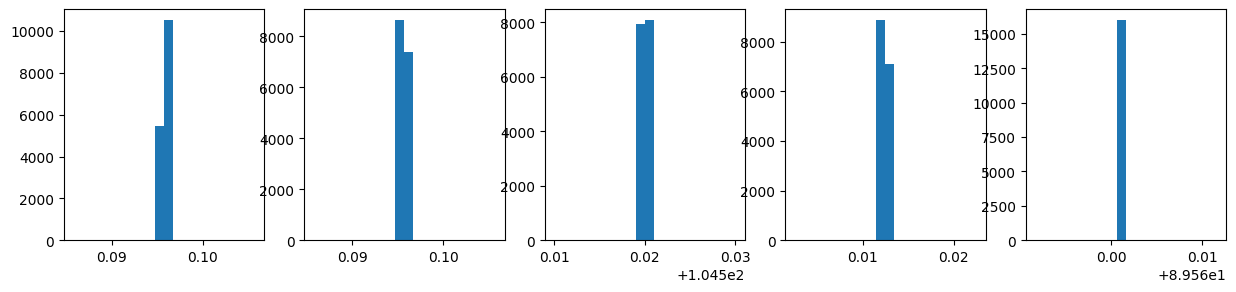

In [232]:
q, p, d_OH1, d_OH2, a_HOH, d_OM, a_OM = jax.vmap(jax.vmap(partial(to_rigid), in_axes=(0, None)))(
    p_.reshape(p_.shape[0], -1, 4, 3),
    geom.Torus(b_),
)
a_HOH = a_HOH * 180 / jnp.pi
a_OM = a_OM * 180 / jnp.pi

plt.figure(figsize=(5 * 3, 3))
for i, x in enumerate([d_OH1.reshape(-1), d_OH2.reshape(-1), a_HOH.reshape(-1), d_OM.reshape(-1), a_OM.reshape(-1)], start=1):
    plt.subplot(1, 5, i)
    plt.hist(x, range=(x.min() - 0.01, x.max() + 0.01), bins=20)

In [237]:
p.shape

(16000, 3)

In [ ]:
q

In [262]:
# import itertools as it
# import matplotlib.colors as mplc


# p = p.reshape(-1, 16, 3)
# q = q.reshape(-1, 16, 4)
# q = q * jnp.sign(q[..., (0,)])

# for l in range(16):

    
#     ijs = list(it.combinations(range(3), r=2))
#     N = len(ijs)
#     plt.figure(figsize=(6, 2))
#     plt.suptitle(f"molecule_{l} pos")
#     for k, (i, j) in enumerate(ijs, start=1):
#         plt.subplot(1, N, k)
#         plt.hist2d(p[:, l, i], p[:, l, j], bins=20, norm=mplc.LogNorm())

#     ijs = list(it.combinations(range(4), r=2))
#     N = len(ijs)
#     plt.figure(figsize=(6, 4))
#     plt.suptitle(f"molecule_{l} quat")
#     for k, (i, j) in enumerate(ijs, start=1):
#         plt.subplot(2, N // 2, k)
#         plt.hist2d(q[:, l, i], q[:, l, j], bins=20, norm=mplc.LogNorm())

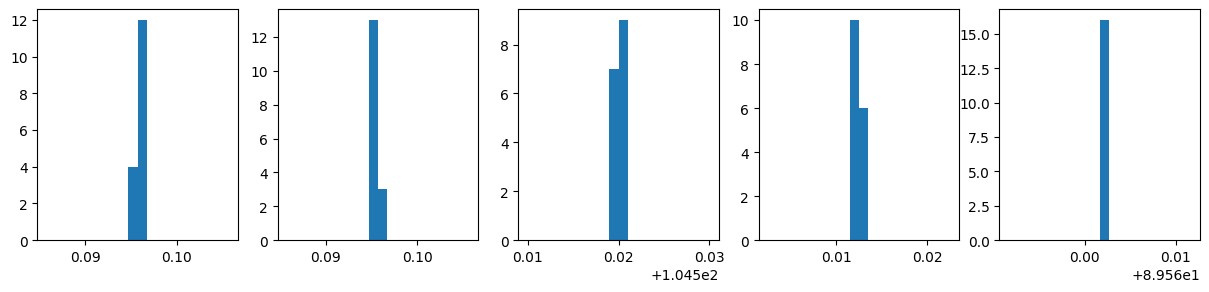

In [183]:
torus = geom.Torus(jnp.diag(box))

def to_rigid(pos, manifold):
    p_O, p_H1, p_H2, p_M = pos
    q, p, d_OH1, d_OH2, a_HOH = rigid.from_euclidean(pos[:3])
    ldj = rigid.from_euclidean_log_jacobian(pos)
    r_OM = manifold.tangent(
        p_O, p_M - p_O
    )
    r_OM = geom.qrot3d(geom.qconj(q), r_OM)
    d_OM = geom.norm(r_OM)
    a_OM = jnp.arccos(geom.inner(r_OM, jnp.array([0., 0., 1.])))
    return q, p, d_OH1, d_OH2, a_HOH, d_OM, a_OM
    
    
q, p, d_OH1, d_OH2, a_HOH, d_OM, a_OM = jax.vmap(partial(to_rigid, manifold=torus))(pos.reshape(-1, 4, 3))
a_HOH = a_HOH * 180 / jnp.pi
a_OM = a_OM * 180 / jnp.pi

plt.figure(figsize=(5 * 3, 3))
for i, x in enumerate([d_OH1, d_OH2, a_HOH, d_OM, a_OM], start=1):
    plt.subplot(1, 5, i)
    plt.hist(x, range=(x.min() - 0.01, x.max() + 0.01), bins=20)

In [261]:
a_OM.min(), a_OM.max()

(DeviceArray(89.56162, dtype=float32), DeviceArray(89.56163, dtype=float32))

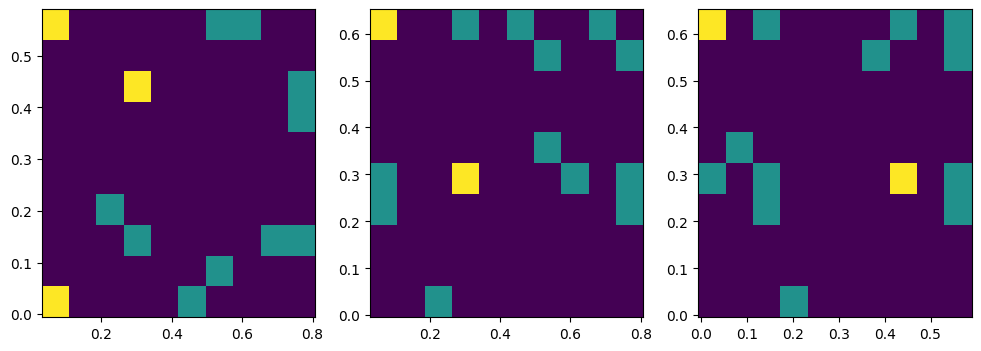

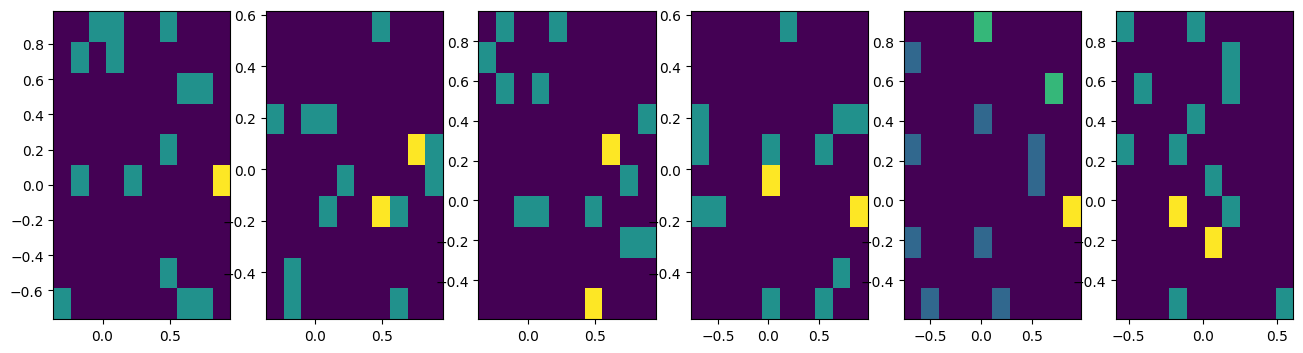

In [263]:
i = 8

q, r, b1, b2, a = rigid.from_euclidean(
    pos_[0 + i * 4:3 + i * 4]
)
q = flox.geom.qconj(q)

r_OH = pos[1 + i*4] - pos[0 + i*4]
r_OH2 = pos[2 + i*4] - pos[0 + i*4]
r_OM = pos[3 + i*4] - pos[0 + i*4]
d_OH = flox.geom.norm(r_OH)
d_OM = flox.geom.norm(r_OM)

flox.geom.norm(pos[3 + i*4] - pos[0 + i*4])
a = jnp.arccos(jnp.inner(r_OH, r_OM) / (d_OH * d_OM)) * 180 / np.pi
b = jnp.arccos(jnp.inner(r_OH, r_OH2) / (d_OH * d_OH)) * 180 / np.pi
a, b

# flox.geom.qrot3d(q, r_OH), flox.geom.qrot3d(q, r_OH2), flox.geom.qrot3d(q, r_OM), 

(DeviceArray(52.259937, dtype=float32), DeviceArray(104.51999, dtype=float32))

In [169]:
jnp.sin(a * np.pi / 180) * d_OM, jnp.cos(a * np.pi / 180) * d_OM

(DeviceArray(0.00988496, dtype=float32),
 DeviceArray(0.00765101, dtype=float32))

In [264]:
import scipy.stats

box_mean = np.array([0.93738384, 0.76394411, 0.74025662])
box_cov = np.array([[ 0.00124461, -0.00053213, -0.00029769],
        [-0.00053213,  0.0007857 , -0.00012568],
        [-0.00029769, -0.00012568,  0.00064462]])

# box_norm.rvs()

In [282]:
%%timeit 
for i in range(100):
    energy(pos, box * np.eye(3))

21.1 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [278]:
from functools import partial

def energy(p, b):
    simulation.context.setPositions(p)
#     box_norm = scipy.stats.multivariate_normal(box_mean, box_cov)
#     b = np.eye(3) * box_norm.rvs()
    simulation.context.setPeriodicBoxVectors(b[0], b[1], b[2])
    state = simulation.context.getState(getEnergy=True, getForces=True)
    energy = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    force = state.getForces(asNumpy=True).value_in_unit(unit.kilojoule_per_mole / unit.nanometer)
    return np.array(energy, np.float32), force.astype(np.float32)


def energy_and_forces(p, b):
    shape_specs = (
        jax.ShapedArray((), jnp.float32),
        jax.ShapedArray(p.shape, jnp.float32)
    )
    return jax.pure_callback(
        energy, shape_specs, p, b
    )

In [284]:
pos_ = jnp.tile(pos[None], (100, 1, 1))
box_ = jnp.tile((box * jnp.eye(3))[None], (100, 1, 1))

In [285]:
%%timeit 
for p, b in zip(pos_, box_):
    energy(pos, box * np.eye(3))

28.2 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [287]:
%%timeit 
jax.jit(jax.vmap(energy_and_forces))(pos_, box_)

118 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
energy_and_forces(pos, box)

(DeviceArray(-795.54675, dtype=float32),
 DeviceArray([[-5.82345398e+02, -3.22835400e+03, -2.57644727e+03],
              [ 7.82603821e+02, -1.67749588e+02,  4.83937714e+02],
              [-1.97130222e+01,  1.38423596e+03,  8.95118286e+02],
              [-9.76645020e+02, -1.15505933e+03, -1.22578894e+03],
              [-1.25539160e+03, -1.00142572e+03, -4.78438232e+02],
              [ 3.05881378e+02,  1.00988910e+03,  1.07713921e+02],
              [ 9.35515503e+02, -7.71954269e+01,  2.85892975e+02],
              [-1.66237793e+03, -1.16154089e+03, -6.26015930e+02],
              [-2.05958252e+03,  2.23778687e+02,  1.33126489e+03],
              [ 5.10429382e+02,  2.23470291e+02, -9.61715210e+02],
              [ 1.07758313e+03,  7.37406372e+02, -5.01718941e+01],
              [-1.10609998e+03, -1.59921069e+03,  9.40104370e+02],
              [-1.14667444e+03, -5.88761353e+02, -1.20450684e+03],
              [ 8.92087524e+02,  4.27576233e+02,  1.37495071e+02],
              [ 1.148

In [ ]:
%timeit energy_and_forces(p, b)[0].block_until_ready()